# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [74]:
import sys
import pickle
import spektral
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from spektral import models
from spektral.models.gnn_explainer import GNNExplainer
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Dropout,
    Dense,
    AveragePooling1D,
    Concatenate,
    Conv1D,
    Flatten,
)
from tensorflow.keras.models import Model

sys.executable

# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [75]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


In [76]:
def calculate_d_band(energy, total_density):
    # total_density = np.sum(densities, axis=1)
    area = np.trapz(total_density, energy)
    # print(area)
    center = np.trapz(energy * total_density, energy) / area
    
    m = []
    m.append(area)
    m.append(center)
    for i in range(5):
        j = i+2
        # j阶中心矩
        moment = np.trapz((energy - center)**j * total_density, energy) / area
        m.append(moment)
    return m

In [77]:
def cal_d(energies, densities):

    # 将能量和态密度数据转换为NumPy数组
    energies_arr = np.array(energies)
    densities_arr = np.array(densities)
    area = np.trapz(densities, energies)
    # 计算中心（平均值）
    center = np.sum(energies_arr * densities_arr) / np.sum(densities_arr)

    # 计算方差
    variance = np.sum(densities_arr * (energies_arr - center)**2) / np.sum(densities_arr)
    deviation = np.sqrt(variance)
    # 计算偏度
    skewness = np.sum(densities_arr * (energies_arr - center)**3) / (np.sum(densities_arr) * variance**(3/2))
    ss = np.sign(skewness)*np.power(np.abs(skewness),1/3)
    # 计算峰度
    kurtosis = np.sum(densities_arr * (energies_arr - center)**4) / (np.sum(densities_arr) * variance**2) - 3
    sk = np.power(kurtosis+3.0,1/4) - np.power(3,1/4)
    m = [area, center, deviation, ss, sk]
    return( m )


# Load Data

In [78]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [79]:
# 从文件中提取数据
file_path = "../shear2/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset3 = pickle.load(file)

print(dataset3)  # 输出：[1, 2, 3, 4, 5]
dataset3[0].x.shape

MyGraphDataset(n_graphs=60)


(8, 4000)

In [80]:
# 从文件中提取数据
file_path = "../shear/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=120)


(8, 4000)

In [81]:
# 从文件中提取数据
data_path = "./vasp_cal/"  # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + "dos_energy_data.pkl"
with open(dos_energy_data_file, "rb") as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=594)


(8, 4000)

In [82]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)

for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)

for i in range(len(dataset3)):
    g = dataset3[i]
    graph_data.append(g)

dataset = MyGraphDataset(graph_data)
dataset

MyGraphDataset(n_graphs=774)

In [83]:
dband = np.sum(graph_data[0].x[0].reshape(-1,5), axis=1)
erange = np.linspace(-7, 1, num=dband.shape[0])
dband.shape

(800,)

In [84]:
erange.shape

(800,)

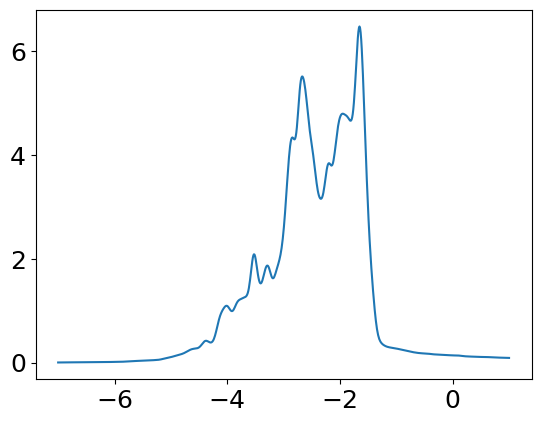

In [85]:
plt.plot(erange, dband)

In [86]:
import copy
graph_data2 = copy.deepcopy(graph_data)
erange = np.linspace(-7, 1, num=dband.shape[0])
for i in range(len(graph_data2)):
    dband = np.sum(graph_data2[i].x[0].reshape(-1,5), axis=1)
    m = np.array(cal_d(erange, dband)) # 计算d带特征
    nx = np.zeros((8,len(m)))
    nx[:6,:] =  m
    graph_data2[i].x = nx
dataset = MyGraphDataset(graph_data2)

In [87]:
graph_data2[1].x

array([[ 9.22738653, -2.44308781,  0.89429982, -0.51913389,  0.13561302],
       [ 9.22738653, -2.44308781,  0.89429982, -0.51913389,  0.13561302],
       [ 9.22738653, -2.44308781,  0.89429982, -0.51913389,  0.13561302],
       [ 9.22738653, -2.44308781,  0.89429982, -0.51913389,  0.13561302],
       [ 9.22738653, -2.44308781,  0.89429982, -0.51913389,  0.13561302],
       [ 9.22738653, -2.44308781,  0.89429982, -0.51913389,  0.13561302],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [88]:
dband = np.sum(graph_data[0].x[0].reshape(-1,5), axis=1)
erange = np.linspace(-7, 1, num=dband.shape[0])
np.array(cal_d(erange, dband))

array([ 9.31010657, -2.43395269,  0.88517846, -0.52696046,  0.13957417])

# New GCN model

In [89]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(5, 4, 1)

In [90]:
learning_rate = 1e-4  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 8  # Batch size

In [91]:
channels = 5
length = int(F / channels)  # 400

In [92]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [93]:
model = Net()
model.layers

In [94]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data2)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [95]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [96]:
istrain = True
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights("./vasp_cal/model_weightas")  # 保存GCN權重
else:
    model.load_weights("./vasp_cal/model_weightas")  # 加载GCN权重

/home/zwbai/miniconda3/envs/gcn/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Loss: 2.231182813644409
Loss: 0.2369794249534607
Loss: 0.19725365936756134
Loss: 0.15886040031909943
Loss: 0.12724031507968903
Loss: 0.11282600462436676
Loss: 0.10250396281480789
Loss: 0.09794128686189651
Loss: 0.09627684205770493
Loss: 0.0958726704120636
Loss: 0.09535108506679535
Loss: 0.09476571530103683
Loss: 0.09334166347980499
Loss: 0.09209362417459488
Loss: 0.09007173031568527
Loss: 0.08739063888788223
Loss: 0.08367422968149185
Loss: 0.07975374162197113
Loss: 0.07907991111278534
Loss: 0.07997008413076401
Loss: 0.07706029713153839
Loss: 0.07391169667243958
Loss: 0.07004552334547043
Loss: 0.061005037277936935
Loss: 0.05404656380414963
Loss: 0.05495524778962135
Loss: 0.05677139386534691
Loss: 0.04657861962914467
Loss: 0.04765496775507927
Loss: 0.04415982961654663
Loss: 0.04396560415625572
Loss: 0.03856820985674858
Loss: 0.035995565354824066
Loss: 0.03478711098432541
Loss: 0.032751698046922684
Loss: 0.032579753547906876
Loss: 0.030062129721045494
Loss: 0.03259357810020447
Loss: 0.029

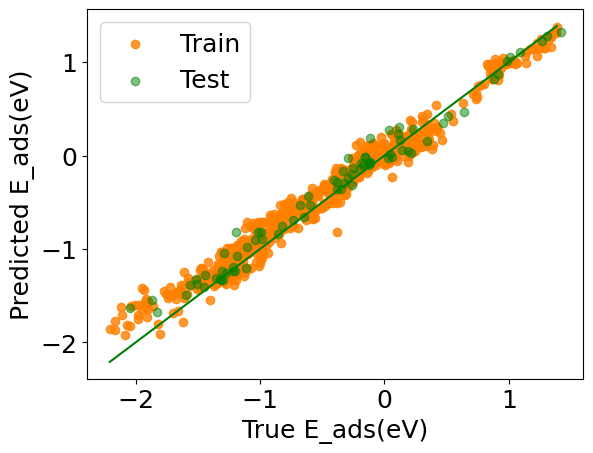

In [97]:
# Train/valid/test split
data = np.array(graph_data2)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

In [119]:
import scipy.stats as stats
import math
from sklearn.metrics import mean_squared_error


# 计算 Pearson 相关系数和 p 值
corr, p_value = stats.pearsonr(data0[:, 1], data0[:, 0])

print("Pearson 相关系数:", corr)
print("p 值:", p_value)

# 计算 Pearson 相关系数和 p 值
corr, p_value = stats.pearsonr(data1[:, 1], data1[:, 0])

print("Pearson 相关系数:", corr)
print("p 值:", p_value)

rmse = math.sqrt(mean_squared_error(data0[:, 1],  data0[:, 0]))
print("RMSE:", rmse)

rmse = math.sqrt(mean_squared_error(data1[:, 1], data1[:, 0]))
print("RMSE:", rmse)

Pearson 相关系数: 0.9880845914576123
p 值: 0.0
Pearson 相关系数: 0.9904952343110236
p 值: 3.065082614081685e-67
RMSE: 0.147887091006054
RMSE: 0.13566060089038973


In [99]:
import shap

In [100]:
def f(X):
    datax = []
    for xi in X:
        data = copy.deepcopy(graph_data2[0])
        data.x[:6] = xi
        datax.append(data)
    loader_x = DisjointLoader(MyGraphDataset(datax), batch_size=1, epochs=1)
    pre = []
    for batch in loader_x:
        output = model(batch[0], training=False)
        pre.append(output.numpy()[0])
    return np.array(pre)

In [101]:
gd = copy.deepcopy(graph_data2[:66])
gdx = np.array([gdi.x[0] for gdi in gd])
gdx = pd.DataFrame(gdx, columns=['Filling', 'Center', 'Width', 'Skew', 'Kurtosis'])
gdx

,Filling,Center,Width,Skew,Kurtosis
0,9.310107,-2.433953,0.885178,-0.526960,0.139574
1,9.227387,-2.443088,0.894300,-0.519134,0.135613
2,9.315330,-2.465828,0.906519,-0.512980,0.128893
3,9.389419,-2.491118,0.920464,-0.522612,0.125349
4,9.311877,-2.448001,0.894363,-0.522318,0.134280
...,...,...,...,...,...
61,9.295125,-2.407414,0.876251,-0.543563,0.141919
62,9.352163,-2.448020,0.895550,-0.533060,0.134373
63,9.309815,-2.463533,0.909207,-0.532622,0.129021
64,9.308180,-2.507561,0.931536,-0.517970,0.119623


In [102]:
explainer = shap.KernelExplainer(f, gdx.iloc[:65])

you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


In [103]:
shap_values = explainer.shap_values(gdx.iloc[-1], nsamples=500)
shap_values[0]

array([-0.03876789,  0.04745005,  0.03031474, -0.01842531,  0.03985146])

In [104]:
gdx.iloc[-1:]

,Filling,Center,Width,Skew,Kurtosis
65,9.389624,-2.474792,0.913261,-0.53543,0.126658


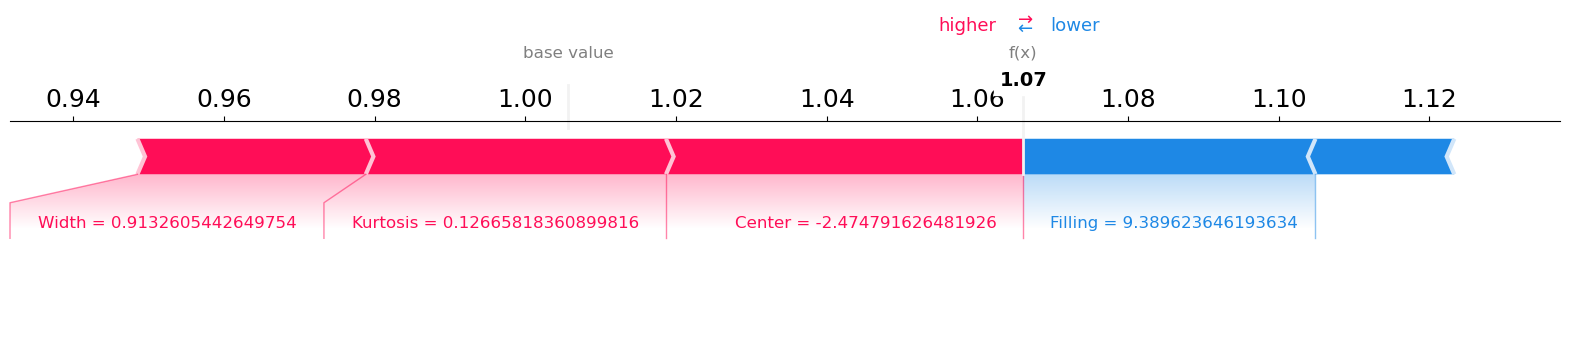

In [105]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], gdx.iloc[-1], matplotlib = True)

In [106]:
shap_values50 = explainer.shap_values( gdx.iloc[:66], nsamples=200)

  0%|          | 0/66 [00:00<?, ?it/s]

you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


In [107]:
shap.force_plot(explainer.expected_value, shap_values50[0], gdx.iloc[:66])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


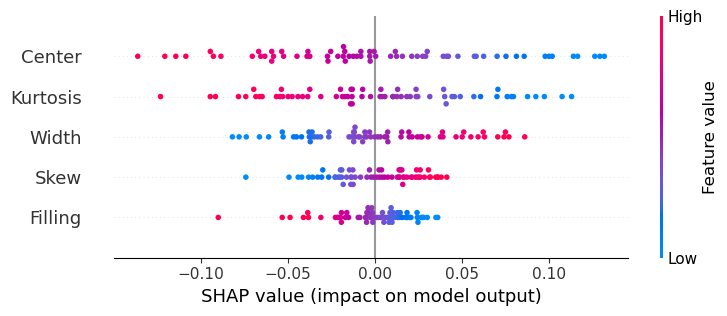

In [108]:
shap.summary_plot(shap_values50[0], gdx.iloc[:66])

In [109]:
gdx['Center']

0    -2.433953
1    -2.443088
2    -2.465828
3    -2.491118
4    -2.448001
        ...   
61   -2.407414
62   -2.448020
63   -2.463533
64   -2.507561
65   -2.474792
Name: Center, Length: 66, dtype: float64

In [110]:
dert_slab_e = [1.2547,  0.3942, -0.6939,  0.1441, -0.5141, -0.4464,  0.0911, -1.2456,  0.2578, -0.5141, -1.2456, -0.6939, -0.4464,] 

In [111]:
len(graph_data2)

774

594 654
654 714


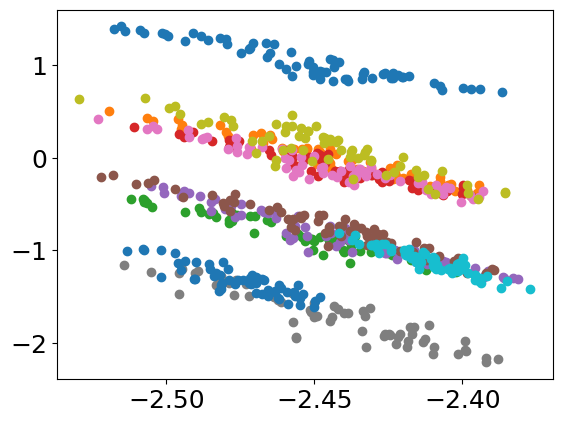

In [112]:
x = np.array([])
y = np.array([])
for i in range(9):
    a = 66*i
    b = a+66
    gd = copy.deepcopy(graph_data2[a:b])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:b])
    gdy = np.array([gdi.y for gdi in gd])
    # gdy = gdy-dert_slab_e[i]
    plt.scatter(gdx[:,1], gdy)
    x = np.concatenate((x ,gdx[:,1]) )
    y = np.concatenate((y, gdy) )
for j in range(2):
    a = 60*j + b
    c = a+60
    print(a, c)
    gd = copy.deepcopy(graph_data2[a:c])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:c])
    gdy = np.array([gdi.y for gdi in gd])
    # gdy = gdy-dert_slab_e[j+i+1]
    plt.scatter(gdx[:,1], gdy)
    x = np.concatenate((x ,gdx[:,1]) )
    y = np.concatenate((y, gdy) )
# for k in range(2):
#     a = 30*k + c
#     d = a+30
#     print(a, c)
#     gd = copy.deepcopy(graph_data2[a:d])
#     gdx = np.array([gdi.x[0] for gdi in gd])

#     gd = copy.deepcopy(graph_data2[a:d])
#     gdy = np.array([gdi.y for gdi in gd])
#     gdy = gdy-dert_slab_e[-(k+1)]
#     plt.scatter(gdx[:,1], gdy)

plt.show()


594 654
654 714


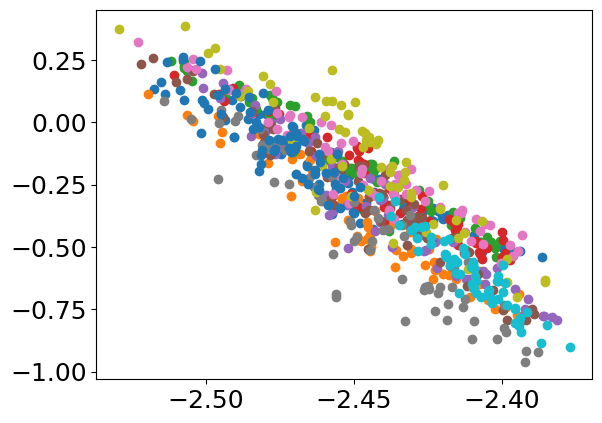

In [113]:
x = np.array([])
y = np.array([])
for i in range(9):
    a = 66*i
    b = a+66
    gd = copy.deepcopy(graph_data2[a:b])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:b])
    gdy = np.array([gdi.y for gdi in gd])
    gdy = gdy-dert_slab_e[i]
    plt.scatter(gdx[:,1], gdy)
    x = np.concatenate((x ,gdx[:,1]) )
    y = np.concatenate((y, gdy) )
for j in range(2):
    a = 60*j + b
    c = a+60
    print(a, c)
    gd = copy.deepcopy(graph_data2[a:c])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:c])
    gdy = np.array([gdi.y for gdi in gd])
    gdy = gdy-dert_slab_e[j+i+1]
    plt.scatter(gdx[:,1], gdy)
    x = np.concatenate((x ,gdx[:,1]) )
    y = np.concatenate((y, gdy) )
# for k in range(2):
#     a = 30*k + c
#     d = a+30
#     print(a, c)
#     gd = copy.deepcopy(graph_data2[a:d])
#     gdx = np.array([gdi.x[0] for gdi in gd])

#     gd = copy.deepcopy(graph_data2[a:d])
#     gdy = np.array([gdi.y for gdi in gd])
#     gdy = gdy-dert_slab_e[-(k+1)]
#     plt.scatter(gdx[:,1], gdy)

plt.show()


In [114]:
import scipy.stats as stats


# 计算 Pearson 相关系数和 p 值
corr, p_value = stats.pearsonr(x, y)

print("Pearson 相关系数:", corr)
print("p 值:", p_value)


Pearson 相关系数: -0.9041367160456524
p 值: 3.630201361972315e-265


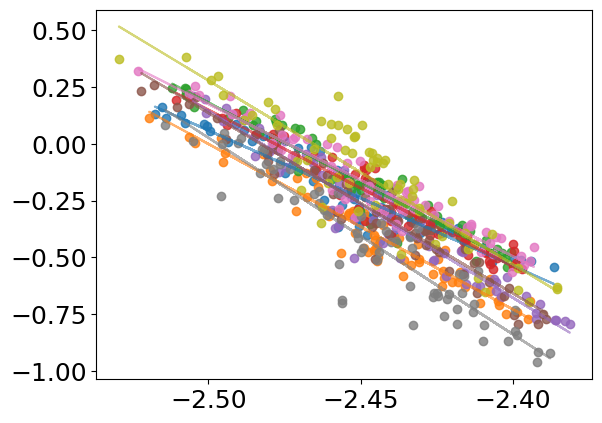

In [115]:
import numpy as np
from scipy.optimize import curve_fit

for i in range(9):
    a = 66 * i
    b = a + 66
    gd = copy.deepcopy(graph_data2[a:b])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:b])
    gdy = np.array([gdi.y for gdi in gd])
    gdy = gdy - dert_slab_e[i]

    # 获取散点集的默认颜色
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    
    # 绘制散点
    plt.scatter(gdx[:, 1], gdy, c=color, alpha=0.8)

    # 拟合直线
    def linear_func(x, k, b):
        return k * x + b

    popt, pcov = curve_fit(linear_func, gdx[:, 1], gdy)
    fitted_y = linear_func(gdx[:, 1], *popt)

    # 绘制拟合直线
    plt.plot(gdx[:, 1], fitted_y, color=color, alpha=0.6)

plt.show()


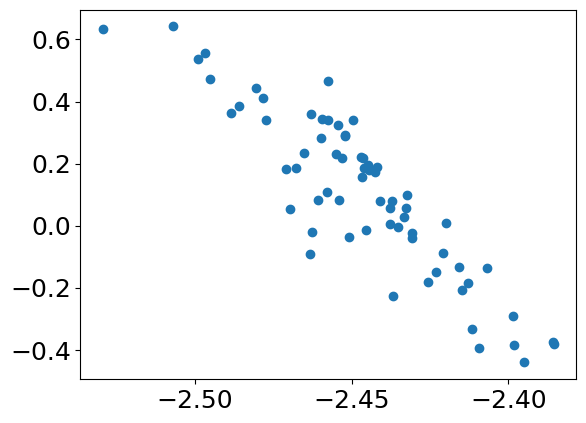

In [116]:
a = 66*8
b = a+66
gd = copy.deepcopy(graph_data2[a:b])
gdx = np.array([gdi.x[0] for gdi in gd])

gd = copy.deepcopy(graph_data2[a:b])
gdy = np.array([gdi.y for gdi in gd])

plt.scatter(gdx[:,1], gdy)
plt.show()

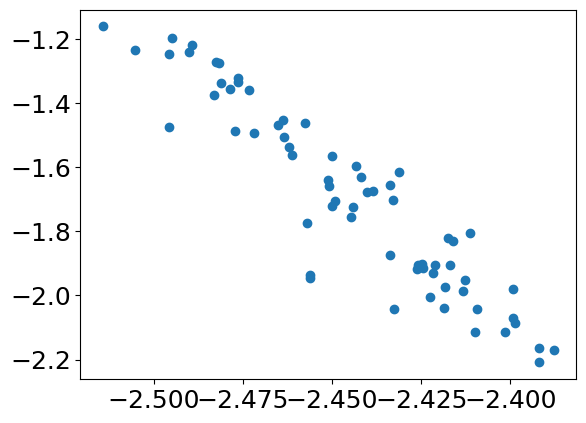

In [117]:
a = 66*7
b = a+66
gd = copy.deepcopy(graph_data2[a:b])
gdx = np.array([gdi.x[0] for gdi in gd])

gd = copy.deepcopy(graph_data2[a:b])
gdy = np.array([gdi.y for gdi in gd])

plt.scatter(gdx[:,1], gdy)
plt.show()

In [118]:
graph_data2[0:66]

[Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=